In [1]:
import os, glob
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

In [2]:
# Import data file
data_directory = 'C:/Users/mvmigem/Documents/data/project_1/raw_data/'
dir_list = glob.glob(data_directory+'sub_*/behav/*.csv')


In [3]:
df_list = []
for i in range(len(dir_list)):
    behav_dat = pd.read_csv(dir_list[i])
    df_list.append(behav_dat)

big_df = pd.concat(df_list,ignore_index=True)

In [4]:
def calculate_subtraction(row):
    if row['catch_trial'] != 0:
        relevant_timepoint_col = f"t_stim_{row['catch_trial']}"
        rt =  row['press_time'] - row[relevant_timepoint_col]
        if rt > 3200:
            return np.nan
        return rt
# Apply the function to create the subtraction column
big_df['rt'] = big_df.apply(calculate_subtraction, axis=1)

In [5]:
"""
***Aestetics***
"""
# load color palette
my_palette = sns.color_palette().as_hex()
sns.color_palette().as_hex()


['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

C:\Users\mvmigem\AppData\Local\Temp\ipykernel_3736\2906674578.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.histplot( x=subject_loc_quad,bins = 4, palette=my_palette[:4], discrete=True)


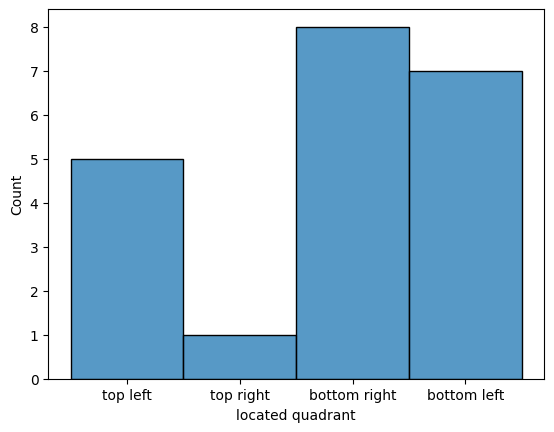

In [19]:
subject_loc_quad = big_df.groupby('participant')['loc_quad'].first()

ax = sns.histplot( x=subject_loc_quad,bins = 4, palette=my_palette[:4], discrete=True)

tick_labels = ['top left', 'top right', 'bottom right','bottom left']  # Replace ... with additional labels

ax.set_xticks(range(4),tick_labels)
ax.set_xlabel('located quadrant')
plt.show()

In [ ]:
palette=my_palette[:4]

In [ ]:
ax = sns.barplot(data= big_df, x='attention',y='rt',
                 edgecolor= 'black', palette= [my_palette[4], my_palette[5]],
                errorbar='se', errwidth= 1.5,
                capsize=.1,width=.6, linewidth=0.7)


In [20]:
sub_grouped = big_df.groupby(['participant','attention'])['rt'].mean()
sub_grouped = sub_grouped.unstack()
t_statistic, p_value = stats.ttest_rel(sub_grouped['attended'], sub_grouped['unattended'])

C:\Users\mvmigem\AppData\Local\Temp\ipykernel_3736\871506653.py:1: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  ax = sns.barplot(data= sub_grouped,


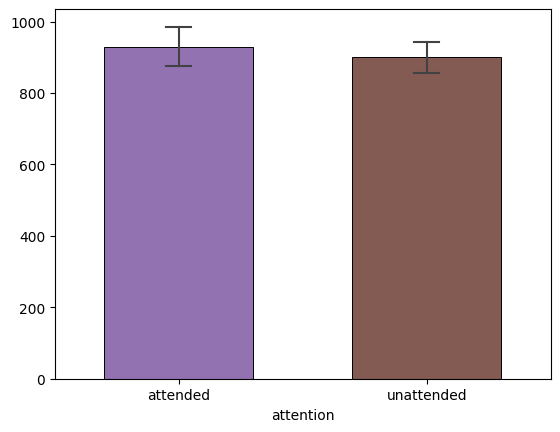

In [21]:
ax = sns.barplot(data= sub_grouped,
                 edgecolor= 'black', palette= [my_palette[4], my_palette[5]],
                errorbar='se', errwidth= 1.5,
                capsize=.1,width=.6, linewidth=0.7)